# Modelo de clasificación usando `RandomForest` y buenas prácticas de la industria

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ymeza@ubiobio.cl

**Fecha de creación:** Noviembre de 2025  
**Versión:** 1.0  

---

## Descripción

Este notebook contiene la construcción de un modelo de clasificación usando `RandomForest` y considerando todas las buenas prácticas de la industria.

Utiliza un conjunto de datos de predicción de abandono de los clientes de los servicios de una empresa de telecomunicaciones.

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.12. A continuación se listan las bibliotecas necesarias:

- `pandas (>=1.1.0)`
- `numpy (2.0.2)`
- `matplotlib (3.10.0)`
- `seaborn (0.13.2)`
- `sklearn (1.6.1)`

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```python
import pandas as pd
print(pd.__version__)
````

In [ ]:
# Descargar el archivo y guardarlo en el entorno
!wget https://raw.githubusercontent.com/JaznaLaProfe/Fundamentos-de-Machine-Learning/master/data/data_clientes_telecomunicaciones.csv


--2025-11-17 22:26:07--  https://raw.githubusercontent.com/JaznaLaProfe/Fundamentos-de-Machine-Learning/master/data/data_clientes_telecomunicaciones.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87589 (86K) [text/plain]
Saving to: ‘data_clientes_telecomunicaciones.csv’

data_clientes_telec 100%[===================>]  85.54K  --.-KB/s    in 0.01s   

2025-11-17 22:26:07 (5.66 MB/s) - ‘data_clientes_telecomunicaciones.csv’ saved [87589/87589]



In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score,  classification_report

In [ ]:
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=(0.05, 0.05)):
        self.limits = limits

    def fit(self, X, y=None):
        # Guardar nombres si es DataFrame, si no generar nombres genéricos
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns
        else:
            self.columns_ = np.arange(X.shape[1])
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.columns_)
        for col in self.columns_:
            lower = X[col].quantile(self.limits[0])
            upper = X[col].quantile(1 - self.limits[1])
            X[col] = np.clip(X[col], lower, upper)
        return X.values

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(self.columns_)
        else:
            return np.array(input_features)

In [ ]:
data = pd.read_csv("data_clientes_telecomunicaciones.csv")
data.head()

,antiguedad_meses,monto_mensual,num_llamadas_soporte,plan,region,usa_app,abandono
0,30.990214,32721.112199,3.0,Plus,Sur,No,0
1,44.472385,33408.472658,0.0,Plus,Norte,Sí,1
2,58.991816,36352.373641,0.0,Premium,Centro,No,0
3,10.298934,17773.059908,1.0,Premium,Norte,Sí,1
4,44.628683,16646.663380,1.0,Básico,Norte,Sí,1


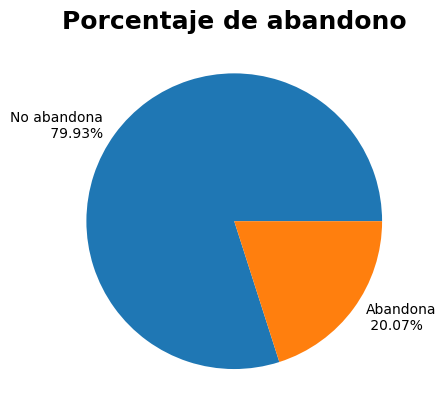

In [ ]:
# Gráfico de torta del porcentaje de abandono de clientes
clases = np.array([data[data.abandono == 0.0].shape[0],
                   data[data.abandono == 1.0].shape[0]])

# Leyendas del gráfico.
labels = [ str(round(x * 1.0 / clases.sum() * 100.0, 2)) + '%'  for x in clases ]
labels[0] = 'No abandona\n ' + labels[0]
labels[1] = 'Abandona\n ' + labels[1]

plt.pie(clases, labels=labels)
plt.title('Porcentaje de abandono', fontsize=18, fontweight="bold")
plt.show()

In [ ]:
# Define las etiquetas de las clases
etiquetas_target = ["No abandona","Abandona"]

In [ ]:
# Recuerda las columnas disponibles
data.columns

Index(['antiguedad_meses', 'monto_mensual', 'num_llamadas_soporte', 'plan',
       'region', 'usa_app', 'abandono'],
      dtype='object')

In [ ]:
# Columnas
num_cols = ["antiguedad_meses", "monto_mensual", "num_llamadas_soporte"]
cat_cols = ["plan", "region", "usa_app"]

# Pipelines
num_pipeline = Pipeline([
    ("winsor", Winsorizer()),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

modelo = Pipeline([
    ("prep", preprocessor),
    ("rf", RandomForestClassifier(
        random_state=29
    ))
])

In [ ]:
param_grid = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [5, 8, 12],
    "rf__min_samples_split": [2, 5],
    "rf__class_weight": ["balanced"]
}

In [ ]:
X = data.drop("abandono", axis=1)
y = data["abandono"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=29
)

In [ ]:
grid = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=29),
    scoring="f1",
    n_jobs=-1
)
# Entrena el modelo
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=29, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('winsor',
                                                                                          Winsorizer()),
                                                                                         ('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['antiguedad_meses',
                                                                          'monto_mensual',
                                                                          'num_llamadas_soporte']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['plan',
                                                                          'region',
                                                                          'usa_app'])])),
                                       ('rf',
                                        RandomForestClassifier(random_state=29))]),
             n_jobs=-1,
             param_grid={'rf__class_weight': ['balanced'],
                         'rf__max_depth': [5, 8, 12],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [100, 200]},
             scoring='f1')

In [ ]:
print("Mejores parámetros encontrados")
print("-"*20)
for indice, parametro in enumerate(grid.best_params_):
  print(f"Parámetro {indice+1} : {parametro :<30} = {grid.best_params_[parametro]}")

Mejores parámetros encontrados
--------------------
Parámetro 1 : rf__class_weight               = balanced
Parámetro 2 : rf__max_depth                  = 5
Parámetro 3 : rf__min_samples_split          = 5
Parámetro 4 : rf__n_estimators               = 100


In [ ]:
mejor_modelo = grid.best_estimator_
mejor_modelo

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('winsor',
                                                                   Winsorizer()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['antiguedad_meses',
                                                   'monto_mensual',
                                                   'num_llamadas_soporte']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['plan', 'region',
                                                   'usa_app'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_split=5,
                                        random_state=29))])

**Características de este modelo**
+ Incluye el mejor `max_depth`
+ Incluye el mejor `min_samples_split`
+ Incluye el mejor `class_weight`
+ Incluye el mejor `n_estimators`
+ Incluye el preprocesamiento con los parámetros correctos
+ En definitiva, está listo para ser usado!!! ⭐

In [ ]:
# Ahora entrena el mejor modelo
mejor_modelo.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('winsor',
                                                                   Winsorizer()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['antiguedad_meses',
                                                   'monto_mensual',
                                                   'num_llamadas_soporte']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['plan', 'region',
                                                   'usa_app'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_split=5,
                                        random_state=29))])

In [ ]:
y_pred_test = mejor_modelo.predict(X_test)
y_proba_test = mejor_modelo.predict_proba(X_test)[:, 1]

print(f"{'ROC-AUC en test' :<22}: {roc_auc_score(y_test, y_proba_test) :.3f}")
print(f"{'Accuracy en test' :<22}:{accuracy_score(y_test, y_pred_test): .3f}")
print(f"{'Precision en test' :<22}:{precision_score(y_test, y_pred_test): .3f}")

ROC-AUC en test       : 0.565
Accuracy en test      : 0.673
Precision en test     : 0.250


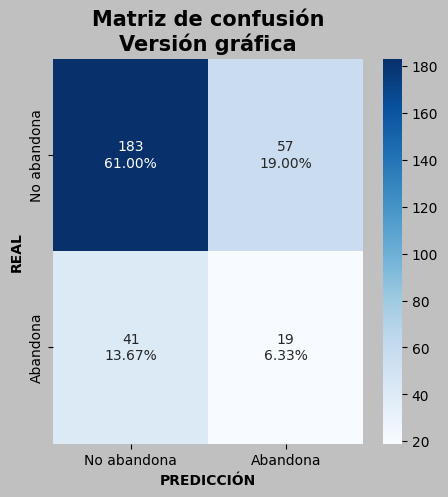

In [ ]:
# Matriz de confusión de forma gráfica
matriz = confusion_matrix(y_test, mejor_modelo.predict(X_test))
plt.figure(figsize=(5,5),facecolor= 'silver')

group_counts = ["{0:0.0f}".format(value) for value in matriz.flatten()]
# Calcula porcentajes
group_percentages = ["{0:.2%}".format(value) for value in matriz.flatten()/matriz.sum()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
# Genera la gráfica
sb.heatmap(matriz, annot=labels, fmt='', cmap='Blues',
           xticklabels=etiquetas_target,
           yticklabels=etiquetas_target)
plt.title("Matriz de confusión\nVersión gráfica", fontsize=15, fontweight="bold")
plt.xlabel("PREDICCIÓN", fontsize=10, fontweight="bold")
plt.ylabel("REAL", fontsize=10, fontweight="bold")
plt.show()

In [ ]:
print(classification_report(
    y_test,
    mejor_modelo.predict(X_test), target_names=etiquetas_target
))

              precision    recall  f1-score   support

 No abandona       0.82      0.76      0.79       240
    Abandona       0.25      0.32      0.28        60

    accuracy                           0.67       300
   macro avg       0.53      0.54      0.53       300
weighted avg       0.70      0.67      0.69       300



# Revisión de `overfitting`

In [ ]:
train_pred = mejor_modelo.predict(X_train)
train_proba = mejor_modelo.predict_proba(X_train)[:, 1]

train_acc = accuracy_score(y_train, train_pred)
train_auc = roc_auc_score(y_train, train_proba)
train_precision = precision_score(y_train, train_pred)
train_f1 = f1_score(y_train, train_pred)

print(f"{'Accuracy en entrenamiento' :<35} : {train_acc :.2f}")
print(f"{'AUC en entrenamiento' : <35} : {train_auc :.2f}")
print(f"{'Precision en entrenamiento' : <35} : {train_precision :.2f}")
print(f"{'F1 score en entrenamiento' : <35} : {train_f1 :.2f}")

Accuracy en entrenamiento           : 0.78
AUC en entrenamiento                : 0.82
Precision en entrenamiento          : 0.47
F1 score en entrenamiento           : 0.52


In [ ]:
test_pred = mejor_modelo.predict(X_test)
test_proba = mejor_modelo.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, test_pred)
test_auc = roc_auc_score(y_test, test_proba)
test_precision = precision_score(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred)

print(f"{'Accuracy en test' :<25} : {test_acc :.2f}")
print(f"{'AUC en test' : <25} : {test_auc :.2f}")
print(f"{'Precision en test' : <25} : {test_precision :.2f}")
print(f"{'F1 score en test' : <25} : {test_f1 :.2f}")

Accuracy en test          : 0.67
AUC en test               : 0.57
Precision en test         : 0.25
F1 score en test          : 0.28


In [ ]:
resumen = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "Accuracy": [train_acc, test_acc],
    "AUC": [train_auc, test_auc],
    "Precision" : [train_precision, test_precision],
    "F1 score" : [train_f1, test_f1]
}).round(4)

display(resumen)

,Dataset,Accuracy,AUC,Precision,F1 score
0,Train,0.7825,0.8217,0.4667,0.5176
1,Test,0.6733,0.5655,0.2500,0.2794


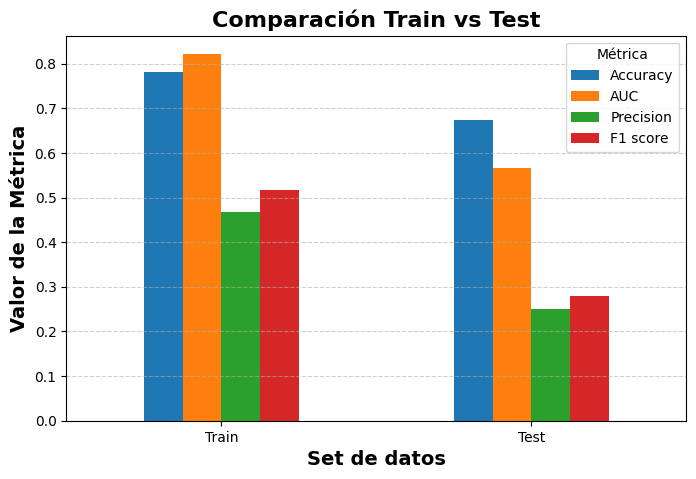

In [ ]:
plt.figure(figsize=(8,5))

ax = resumen.set_index("Dataset").plot(kind="bar", ax=plt.gca())
plt.title("Comparación Train vs Test", fontsize=16, fontweight="bold")
plt.ylabel("Valor de la Métrica", fontsize=14, fontweight="bold")
plt.xlabel("Set de datos", fontsize=14, fontweight="bold")
plt.xticks(rotation=0)
plt.legend(title="Métrica")
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

| Situación                               | Interpretación  |
| --------------------------------------- | --------------- |
| **Train muy alto, Test mucho más bajo** | Overfitting     |
| **Train y Test similares y buenos**     | Modelo correcto |
| **Train y Test similares pero bajos**   | Underfitting    |

En general:

+ Si Accuracy_train >> Accuracy_test entonces **probable overfitting o sobreajuste**.

+ Si AUC_train >> AUC_test entonces **aún más claro el sobreajuste**.

+ Si las métricas están cercanas entonces **modelo logra generalizar bien**.


Cuando hay desbalance de clases, las métricas más útiles para detectar overfitting suelen ser:

+ F1

+ Precision / Recall

+ ROC-AUC


# Importancia de las variables

In [ ]:
importances = mejor_modelo.named_steps["rf"].feature_importances_
feature_names = mejor_modelo.named_steps["prep"].get_feature_names_out()

pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False).head(10)


,feature,importance
1,num__monto_mensual,0.289180
0,num__antiguedad_meses,0.284413
2,num__num_llamadas_soporte,0.145230
7,cat__region_Norte,0.058752
6,cat__region_Centro,0.038050
4,cat__plan_Plus,0.037024
3,cat__plan_Básico,0.034747
10,cat__usa_app_Sí,0.033211
9,cat__usa_app_No,0.031967
8,cat__region_Sur,0.024086
